# Vision Agents with smolagents
- Empowering agents with visual capabilities is crucial for solving tasks that go beyond text processing. Many real-world challenges, such as web browsing or document understanding, require analyzing rich visual content. 

- In this approach, images are passed to the agent at the start and stored as task_images alongside the task prompt. The agent then processes these images throughout its execution.


In [5]:
from PIL import Image
import requests
from io import BytesIO
image_urls=[
    "https://upload.wikimedia.org/wikipedia/commons/e/e8/The_Joker_at_Wax_Museum_Plus.jpg", # Joker image
    "https://upload.wikimedia.org/wikipedia/en/9/98/Joker_%28DC_Comics_character%29.jpg"
]
images=[]
for url in image_urls:
    headers={
        "User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
    }
    response=requests.get(url,headers=headers)
    image=Image.open(BytesIO(response.content)).convert("RGB")
    images.append(image)

In [6]:
from smolagents import CodeAgent, OpenAIServerModel
model=OpenAIServerModel(model_id="gpt-4o")
agent=CodeAgent(
    tools=[],
    model=model,
    max_steps=20,
    verbosity_level=2
)
response=agent.run(
    """
    Describe the costume and makeup that the comic character in these photos is wearing and return the description.
    Tell me if the guest is The Joker or Wonder Woman.
    """,
    images=images
)

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Describe the costume and makeup that the comic character in these photos is wearing and return the description. │
│     Tell me if the guest is The Joker or Wonder Woman.                                                          │
│                                                                                                                 │
╰─ OpenAIServerModel - gpt-4o ────────────────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Error in generating model output:
Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing 
details. For more information on this error, read the docs: 
https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 
'code': 'insufficient_quota'}}

[Step 1: Duration 19.60 seconds]

AgentGenerationError: Error in generating model output:
Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [ ]:
output= {
        'Costume and Makeup - First Image': (
            'Purple coat and a purple silk-like cravat or tie over a mustard-yellow shirt.',
            'White face paint with exaggerated features, dark eyebrows, blue eye makeup, red lips forming a wide smile.'
        ),
        'Costume and Makeup - Second Image': (
            'Dark suit with a flower on the lapel, holding a playing card.',
            'Pale skin, green hair, very red lips with an exaggerated grin.'
        ),
        'Character Identity': 'This character resembles known depictions of The Joker from comic book media.'
    }

- Images are dynamically added to the agent's memory during execution. MultiStepAgent is an abstraction of the ReAct framweork. 
- This class operates in a structured cycle where various variables and knowledge are logged at different stages:
    * SystemPromptStep: stores the system prompt.
    * TaskStep: Logs the user query and any provided input.
    * ActionStep: Capturees logs from the agent's actions and results.
- 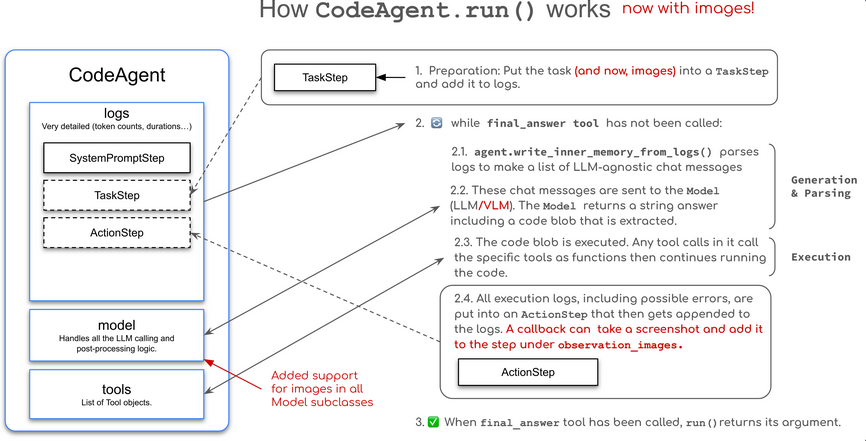


In [8]:
from smolagents import tool
@tool
def search_item_ctrl_f(text: str, nth_result: int =1)->str:
    """
    Searches for text on the current page via Ctrl + F and jumps to the nth occurence.
    Args:
        text: The text to search for
        nth_result: which occurence to jump to (default: 1)
    """
    elements=driver.find_elements(By.XPATH,f"//*[contains(text(),'{text}')]")
    if nth_result>len(elements):
        raise Exception(f"Match n°{nth_result} not found (only {len(elements)} matches found)")
    result = f"Found {len(elements)} matches for '{text}'."
    elem = elements[nth_result - 1]
    driver.execute_script("arguments[0].scrollIntoView(true);", elem)
    result += f"Focused on element {nth_result} of {len(elements)}"
    return result



def go_back() -> None:
    """Goes back to previous page."""
    driver.back()



def close_popups() -> str:
    """
    Closes any visible modal or pop-up on the page. Use this to dismiss pop-up windows! This does not work on cookie consent banners.
    """
    webdriver.ActionChains(driver).send_keys(Keys.ESCAPE).perform()

In [9]:
def save_screenshot(step_log: ActionStep, agent: CodeAgent) -> None:
    sleep(1.0)  # Let JavaScript animations happen before taking the screenshot
    driver = helium.get_driver()
    current_step = step_log.step_number
    if driver is not None:
        for step_logs in agent.logs:  # Remove previous screenshots from logs for lean processing
            if isinstance(step_log, ActionStep) and step_log.step_number <= current_step - 2:
                step_logs.observations_images = None
        png_bytes = driver.get_screenshot_as_png()
        image = Image.open(BytesIO(png_bytes))
        print(f"Captured a browser screenshot: {image.size} pixels")
        step_log.observations_images = [image.copy()]  # Create a copy to ensure it persists, important!

    # Update observations with current URL
    url_info = f"Current url: {driver.current_url}"
    step_log.observations = url_info if step_logs.observations is None else step_log.observations + "\n" + url_info
    return

NameError: name 'ActionStep' is not defined

In [10]:
from smolagents import CodeAgent, OpenAIServerModel, DuckDuckGoSearchTool
model = OpenAIServerModel(model_id="gpt-4o")

agent = CodeAgent(
    tools=[DuckDuckGoSearchTool(), go_back, close_popups, search_item_ctrl_f],
    model=model,
    additional_authorized_imports=["helium"],
    step_callbacks=[save_screenshot],
    max_steps=20,
    verbosity_level=2,
)

NameError: name 'save_screenshot' is not defined

In [11]:
agent.run("""
I am Alfred, the butler of Wayne Manor, responsible for verifying the identity of guests at party. A superhero has arrived at the entrance claiming to be Wonder Woman, but I need to confirm if she is who she says she is.

Please search for images of Wonder Woman and generate a detailed visual description based on those images. Additionally, navigate to Wikipedia to gather key details about her appearance. With this information, I can determine whether to grant her access to the event.
""" + helium_instructions)

NameError: name 'helium_instructions' is not defined